# Week 1: Working with time series

Welcome! In this assignment you will be working with time series data. All of the data is going to be generated and you will implement several functions to split the data, create forecasts and evaluate the quality of those forecasts.


Let's get started!

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)

## Generate time series data

Using the previous functions, generate data that resembles a real-life time series.

Notice that `TIME` represents the values in the x-coordinate while `SERIES` represents the values in the y-coordinate. This naming is used to avoid confusion with other kinds of data in which `x` and `y` have different meanings.

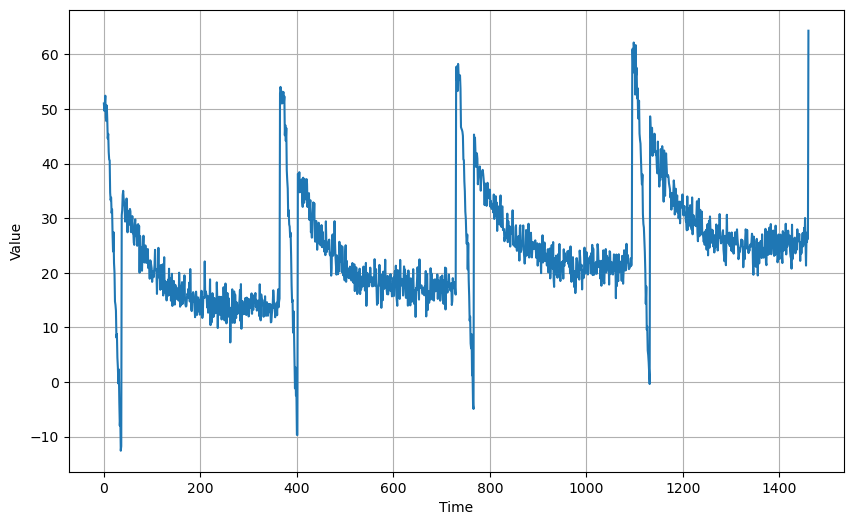

In [3]:
# The time dimension or the x-coordinate of the time series
TIME = np.arange(4 * 365 + 1, dtype="float32")

# Initial series is just a straight line with a y-intercept
y_intercept = 10
slope = 0.01
SERIES = trend(TIME, slope) + y_intercept

# Adding seasonality
amplitude = 40
SERIES += seasonality(TIME, period=365, amplitude=amplitude)

# Adding some noise
noise_level = 2
SERIES += noise(TIME, noise_level, seed=42)

# Plot the series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

Now that we have the time series, let's split it so we can start forecasting.

Complete the `train_val_split` function below which receives the `time` (x coordinate) and `series` (y coordinate) data along with the `time_step` in which to perform the split. Notice that this value defaults to 1100 since this is an appropiate step to split the series into training and validation:

In [5]:
# Define time step to split the series
SPLIT_TIME = 1100

# GRADED FUNCTION: train_val_split
def train_val_split(time, series, time_step=SPLIT_TIME):

    ### START CODE HERE
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    ### END CODE HERE

    return time_train, series_train, time_valid, series_valid

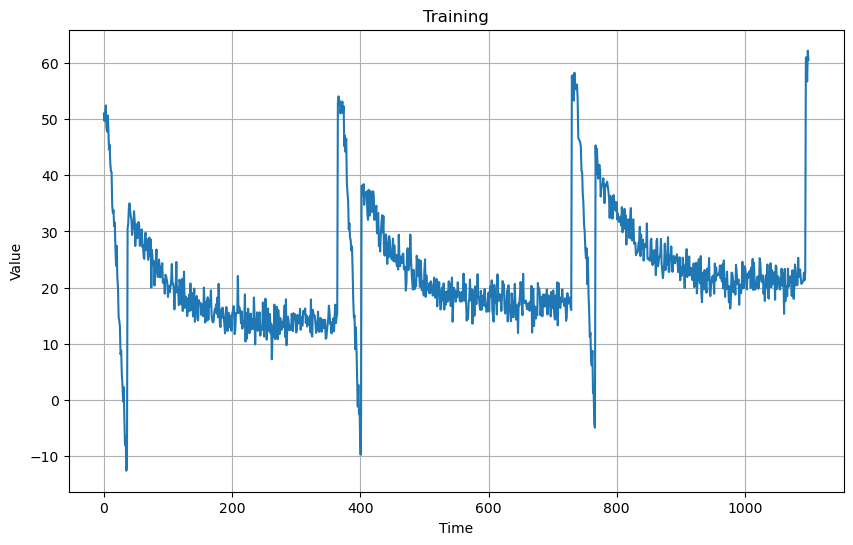

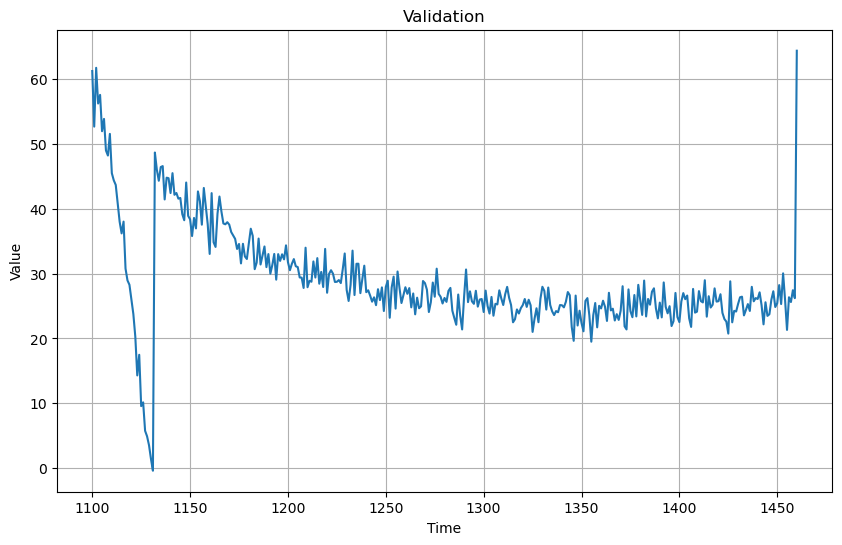

In [6]:
# Test your function
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

plt.figure(figsize=(10, 6))
plot_series(time_train, series_train, title="Training")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, title="Validation")
plt.show()

**Expected Output:**

<table><tr><td><img src='images/train_series.png'></td><td><img src='images/val_series.png'></td></tr></table>

## Evaluation Metrics

Now that you have successfully splitted the data into training and validation sets you will need a way of knowing how good your forecasts are. For this complete the `compute_metrics` below. This function receives the true series and the forecast and returns the `mse` and the `mae` between the two curves. These metrics should be numpy numeric types. 

**Notice that this function does not receive any time (x coordinate) data since it assumes that both series will have the same values for the x coordinate.**

In [7]:
# GRADED FUNCTION: compute_metrics
def compute_metrics(true_series, forecast):
    
    ### START CODE HERE
    errors = forecast - true_series
    mse = np.square(errors).mean()
    mae = np.abs(errors).mean()
    ### END CODE HERE

    return mse, mae

In [8]:
# Test your function

# Define some dummy series for testing
zeros = np.zeros(5)
ones = np.ones(5)

mse, mae = compute_metrics(zeros, ones)
print(f"mse: {mse}, mae: {mae} for series of zeros and prediction of ones\n")

mse, mae = compute_metrics(ones, ones)
print(f"mse: {mse}, mae: {mae} for series of ones and prediction of ones\n")

print(f"metrics are numpy numeric types: {np.issubdtype(type(mse), np.number)}")

mse: 1.0, mae: 1.0 for series of zeros and prediction of ones

mse: 0.0, mae: 0.0 for series of ones and prediction of ones

metrics are numpy numeric types: True


**Expected Output:**

```
mse: 1.0, mae: 1.0 for series of zeros and prediction of ones

mse: 0.0, mae: 0.0 for series of ones and prediction of ones

metrics are numpy numeric types: True
```

# Forecasting

Now that you have a way of measuring the performance of your forecasts it is time to actually start doing some forecasts.

Let's start easy by using a naive forecast.

## Naive Forecast

Define the `naive_forecast` variable below. This series should be identical to the validation one but delayed one time step. It also receives the split time step of the series for ease of computing the delayed series.

**Notice that this series should leave out the last element since this element does not exists in the validation set and you will not be able to compute the evaluation metrics if this element is kept.**

Hint:

- Use the whole `SERIES` (training and validation) and the `SPLIT_TIME` to compute this one.

validation series has shape: (361,)

naive forecast has shape: (361,)

comparable with validation series: True


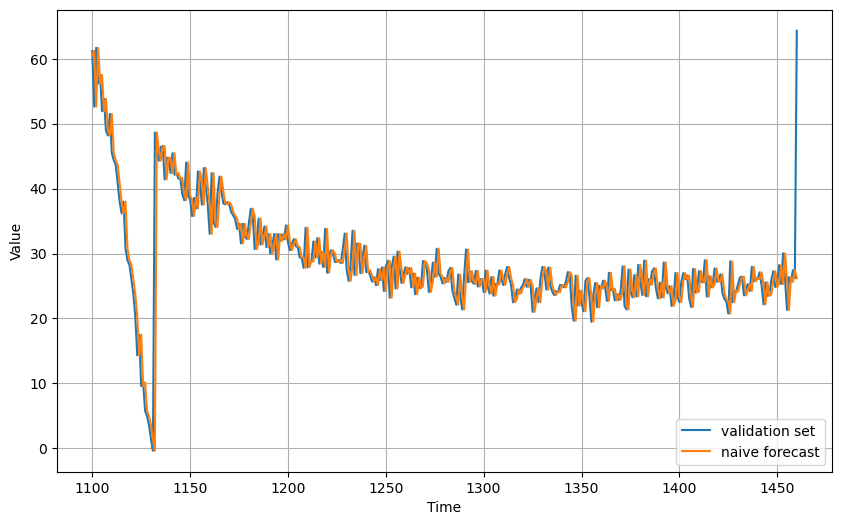

In [10]:
### START CODE HERE
naive_forecast = SERIES[SPLIT_TIME - 1:-1]
### END CODE HERE

print(f"validation series has shape: {series_valid.shape}\n")
print(f"naive forecast has shape: {naive_forecast.shape}\n")
print(f"comparable with validation series: {series_valid.shape == naive_forecast.shape}")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, label="validation set")
plot_series(time_valid, naive_forecast, label="naive forecast")

**Expected Output:**

```
validation series has shape: (361,)

naive forecast has shape: (361,)

comparable with validation series: True
```
<div>
<img src="images/naive.png" width="500"/>
</div>

Let's zoom in on the end of the validation period:

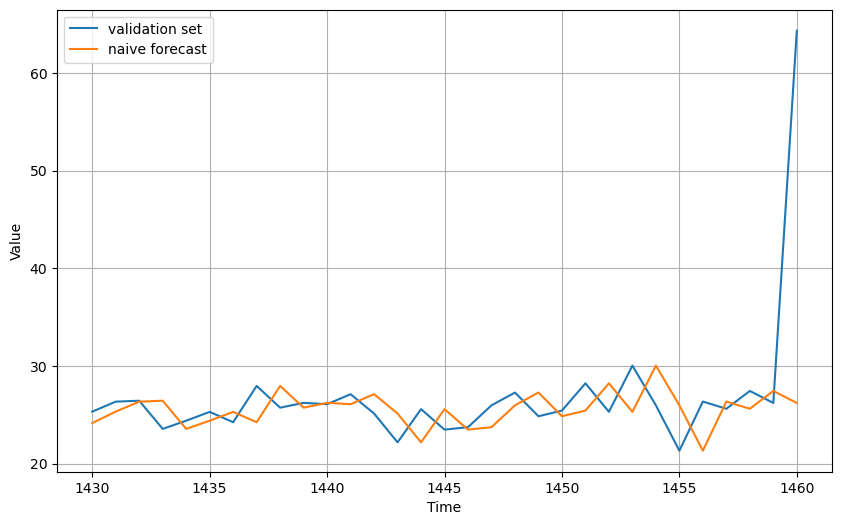

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, start=330, end=361, label="validation set")
plot_series(time_valid, naive_forecast, start=330, end=361, label="naive forecast")

**Expected Output:**

<div>
<img src="images/naive_zoom.png" width="500"/>
</div>

**You should see that the naive forecast lags 1 step behind the time serie and that both series end on the same time step.**

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [12]:
mse, mae = compute_metrics(series_valid, naive_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for naive forecast")

mse: 19.58, mae: 2.60 for naive forecast


**Expected Output:**

```
mse: 19.58, mae: 2.60 for naive forecast
```

That's our baseline, now let's try a moving average.

## Moving Average

Complete the `moving_average_forecast` below. This function receives a `series` and a `window_size` and computes the moving average forecast for every point after the initial `window_size` values.

**This function will receive the complete `SERIES` and the returned series will then be sliced to match the validation period so your function doesn't need to account for matching the series to the validation period.**

In [13]:
# GRADED FUNCTION: moving_average_forecast
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast"""
    
    forecast = []
    
    ### START CODE HERE  
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
        
    # Convert to a numpy array
    np_forecast = np.array(forecast)
    
    ### END CODE HERE
    
    return np_forecast

You cannot compute the moving average for the first `window_size` values since there aren't enough values to compute the desired average. So if you use the whole `SERIES` and a `window_size` of 30 your function should return a series with the number of elements equal to:

```python
len(SERIES) - 30
````

In [14]:
print(f"Whole SERIES has {len(SERIES)} elements so the moving average forecast should have {len(SERIES)-30} elements")

Whole SERIES has 1461 elements so the moving average forecast should have 1431 elements


moving average forecast with whole SERIES has shape: (1431,)

moving average forecast after slicing has shape: (361,)

comparable with validation series: True


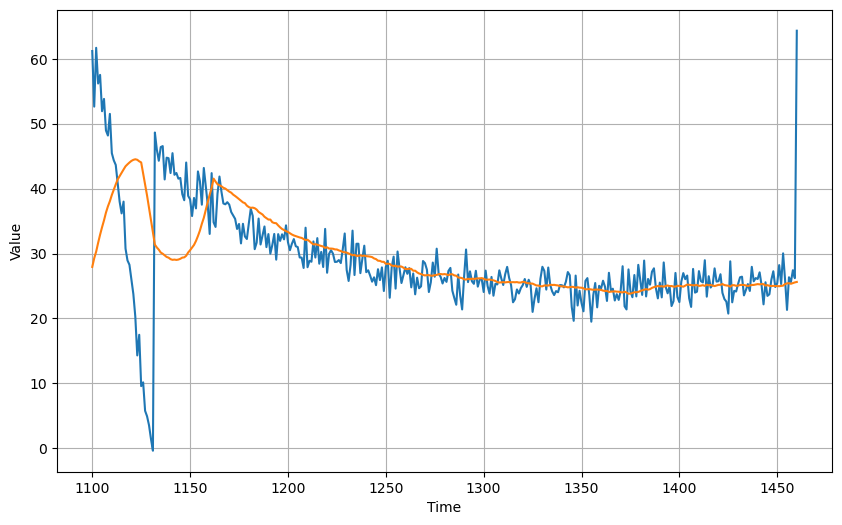

In [15]:
# Test your function
moving_avg = moving_average_forecast(SERIES, window_size=30)
print(f"moving average forecast with whole SERIES has shape: {moving_avg.shape}\n")

# Slice it so it matches the validation period
moving_avg = moving_avg[1100 - 30:]
print(f"moving average forecast after slicing has shape: {moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == moving_avg.shape}")


plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, moving_avg)

**Expected Output:**

```
moving average forecast with whole SERIES has shape: (1431,)

moving average forecast after slicing has shape: (361,)

comparable with validation series: True
```
<div>
<img src="images/moving_avg.png" width="500"/>
</div>

In [16]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, moving_avg)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average forecast")

mse: 65.79, mae: 4.30 for moving average forecast


**Expected Output:**

```
mse: 65.79, mae: 4.30 for moving average forecast
```

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. 

## Differencing

Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

Define the `diff_series` and `diff_time` variables below to achieve this. Notice that `diff_time` is the values of the x-coordinate for `diff_series`.

Whole SERIES has 1461 elements so the differencing should have 1096 elements

diff series has shape: (1096,)

x-coordinate of diff series has shape: (1096,)



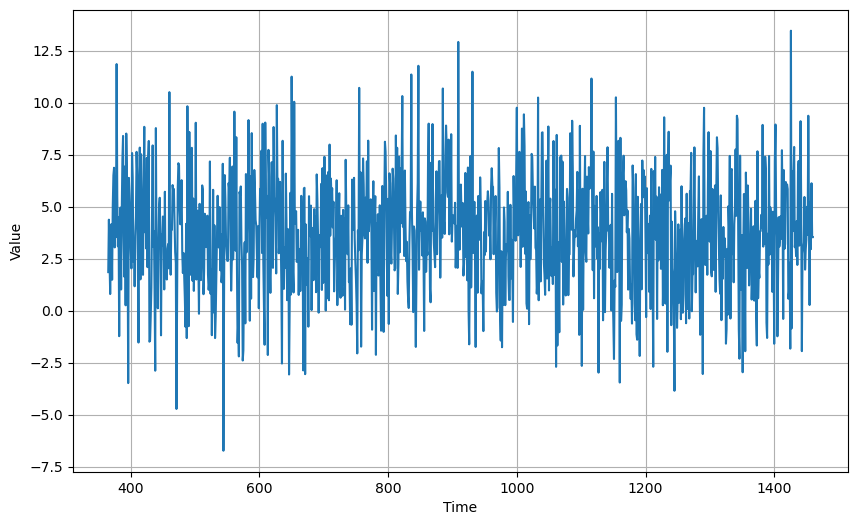

In [17]:
### START CODE HERE
diff_series = (SERIES[365:] - SERIES[:-365])
diff_time = TIME[365:]
### END CODE HERE

print(f"Whole SERIES has {len(SERIES)} elements so the differencing should have {len(SERIES)-365} elements\n")
print(f"diff series has shape: {diff_series.shape}\n")
print(f"x-coordinate of diff series has shape: {diff_time.shape}\n")

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

**Expected Output:**
```
Whole SERIES has 1461 elements so the differencing should have 1096 elements

diff series has shape: (1096,)

x-coordinate of diff series has shape: (1096,)
```
<div>
<img src="images/diff.png" width="500"/>
</div>

Great, the trend and seasonality seem to be gone, so now we can use the moving average.

Define the `diff_moving_avg` variable. 

**Notice that the `window_size` has already being defined and that you will need to perform the correct slicing for the series to match the validation period.**

moving average forecast with diff series has shape: (1046,)

moving average forecast with diff series after slicing has shape: (361,)

comparable with validation series: True


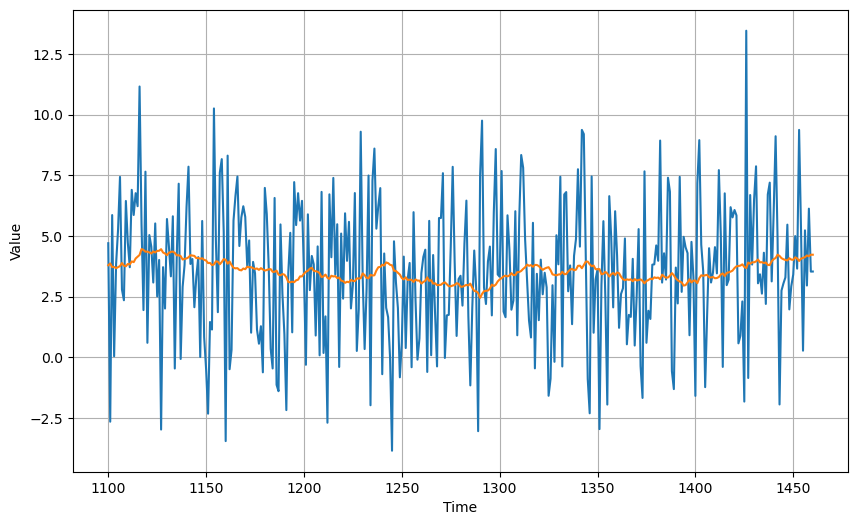

In [19]:
### START CODE HERE

# Apply the moving avg to diff series
diff_moving_avg = moving_average_forecast(diff_series, 50)

print(f"moving average forecast with diff series has shape: {diff_moving_avg.shape}\n")

# Perform the correct slicing
diff_moving_avg = diff_moving_avg[SPLIT_TIME - 365 - 50:]

### END CODE HERE

print(f"moving average forecast with diff series after slicing has shape: {diff_moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg.shape}")


plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[1100 - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

**Expected Output:**
```
moving average forecast with diff series has shape: (1046,)

moving average forecast with diff series after slicing has shape: (361,)

comparable with validation series: True
```
<div>
<img src="images/diff_moving.png" width="500"/>
</div>

Now let's bring back the trend and seasonality by adding the past values from t – 365:

past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


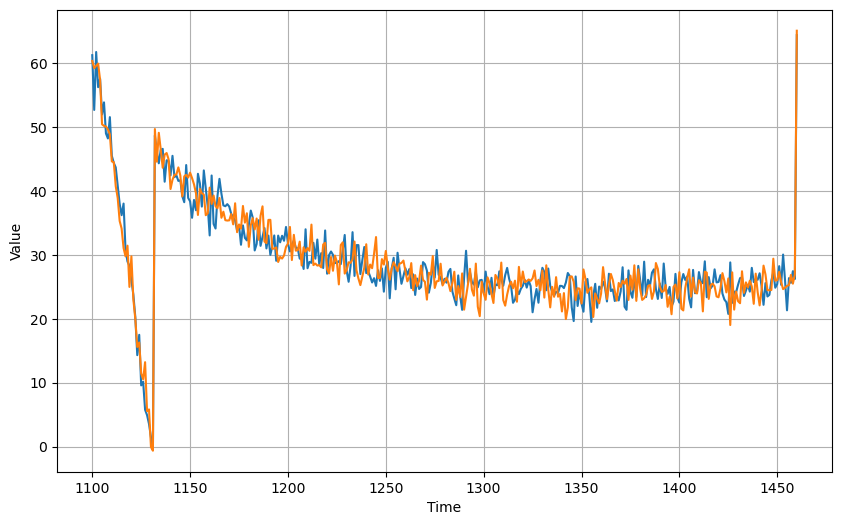

In [20]:
### START CODE HERE

# Slice the whole SERIES to get the past values
past_series = SERIES[SPLIT_TIME - 365:-365]

print(f"past series has shape: {past_series.shape}\n")


# Add the past to the moving average of diff series
diff_moving_avg_plus_past = past_series + diff_moving_avg

### END CODE HERE

print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_past.shape}")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

**Expected Output:**

```
past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True
```

<div>
<img src="images/plus_past.png" width="500"/>
</div>

In [21]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus past forecast")

mse: 8.50, mae: 2.33 for moving average plus past forecast


**Expected Output:**

```
mse: 8.50, mae: 2.33 for moving average plus past forecast
```

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

smooth past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


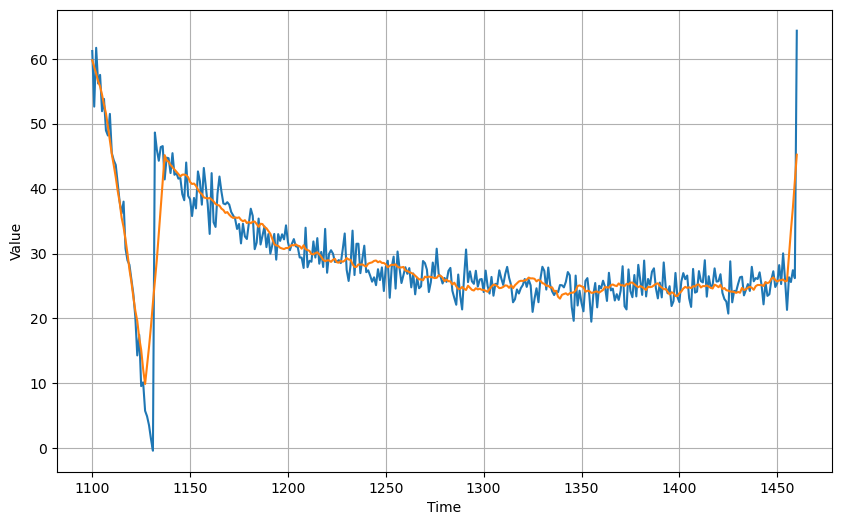

In [23]:
### START CODE HERE

# Perform the correct split of SERIES
smooth_past_series = moving_average_forecast(SERIES[SPLIT_TIME - 370:-360], 10)

print(f"smooth past series has shape: {smooth_past_series.shape}\n")

# Add the smoothed out past values to the moving avg of diff series
diff_moving_avg_plus_smooth_past = smooth_past_series + diff_moving_avg

### END CODE HERE

print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_smooth_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_smooth_past.shape}")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

**Expected Output:**

```
smooth past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True
```

<div>
<img src="images/plus_smooth.png" width="500"/>
</div>

In [24]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_smooth_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus smooth past forecast")

mse: 12.53, mae: 2.20 for moving average plus smooth past forecast


**Expected Output:**

```
mse: 12.53, mae: 2.20 for moving average plus smooth past forecast
```

**Congratulations on finishing this week's assignment!**

You have successfully implemented functions for time series splitting and evaluation while also learning how to deal with time series data and how to code forecasting methods!

**Keep it up!**